## ANLP Assignment 1: Sentiment Analysis
### Arpan Mukhopadhyay,  a1797378

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string

### 1. Reading dataset and initial pre-processing

In [9]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    lang_title = detect(json_line['title'])
                    if lang == "en" and lang_title == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

exception
exception
exception


In [10]:
original_data = pd.read_json('hotel_reviews_train.JSON', lines=True)
train_data = pd.read_json("hotel_review_en_train.JSON", lines=True)

#checking to see the difference in reviews after removal of non english reviews
print(len(original_data))
print(len(train_data))

24000
19568


In [11]:
test_data = pd.read_json("hotel_review_en_test.JSON", lines=True)
print(len(test_data))

4902


In [12]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [13]:
train_data['title']

0                      “Great location and service”
1                “I will never go back here again!”
2        “Ripped off our VISA card after departure”
3                               “A great location!”
4                     “It's all about the Location”
                            ...                    
19563            “pleasant stay with good location”
19564     “Hit or miss, some things need attention”
19565                              “Good breakfast”
19566                    “Deserves a higher rating”
19567                        “Clean & comfortable!”
Name: title, Length: 19568, dtype: object

In [7]:
train_data['text'][0]

'First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightmare of a hotel.\nDon\'t ever write reviews but this one was called for, if you can avoid this hotel do it.\n(Being a military family and movin

In [16]:
#omitting lowercase for now
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]','',text)
        text = re.sub(r'[\n\r\t]', ' ',text)
        text = re.sub(r'\s+', ' ', text)
        text.translate(text.maketrans('', '', string.punctuation)) #added just as a final sanity check if stuff was missed
        return text.strip()
    return ""

train_data['clean_title'] = train_data['title'].apply(clean_text)
train_data['clean_text'] = train_data['text'].apply(clean_text)

test_data['clean_title'] = test_data['title'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [17]:
train_data['text'][0]

"Close to Union Square - hotel is a bit of a maze to get to the lobby. Rooms are quickly accessed via speedy elevators. Rooms are highly funcational with flat screen large TV's and bed have pillow tops. All very good and what you would expect from a 4 star plus hotel."

In [19]:
train_data['clean_text'][0]

'Close to Union Square hotel is a bit of a maze to get to the lobby Rooms are quickly accessed via speedy elevators Rooms are highly funcational with flat screen large TVs and bed have pillow tops All very good and what you would expect from a 4 star plus hotel'

### 2. Exploratory Data Analysis (EDA)

In [20]:
print(train_data.columns)
print(test_data.columns)

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')
Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile', 'clean_title',
       'clean_text'],
      dtype='object')


In [21]:
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
0,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,Great location and service,Close to Union Square hotel is a bit of a maze...
1,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,I will never go back here again,I had a bad vibe about this place from the mom...
2,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,Ripped off our VISA card after departure,After we received our final bill and left the ...
3,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“A great location!”,"Steps to Grand Central, a very well situated h...","{'username': 'bfischer1', 'num_cities': 6, 'nu...",September 2011,99327,0,2011-10-19,119481493,False,A great location,Steps to Grand Central a very well situated ho...
4,"{'service': 3.0, 'cleanliness': 3.0, 'overall'...",“It's all about the Location”,This Hotel is located right in the heart of Sa...,"{'username': 'leeanne39', 'num_reviews': 2, 'n...",June 2009,81377,0,2010-08-30,77535380,False,Its all about the Location,This Hotel is located right in the heart of Sa...


In [22]:
missing_overall_rating = train_data[~train_data['ratings'].apply(lambda x: 'overall' in x)]
missing_overall_rating

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [23]:
max_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).max()
mean_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).mean()
min_words = train_data['clean_text'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review: {min_words} words", 
      f"\nAverage length of review: {round(mean_words,3)} words", 
      f"\nLongest review: {max_words} words")

Shortest review: 4 words 
Average length of review: 156.614 words 
Longest review: 2239 words


In [24]:
max_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).max()
mean_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).mean()
min_title_length = train_data['clean_title'].apply(lambda x: len(str(x).split())).min()

print(f"Shortest review title: {min_title_length} words", 
      f"\nAverage length of review title: {round(mean_title_length ,3)} words", 
      f"\nLongest review title: {max_title_length} words")

Shortest review title: 1 words 
Average length of review title: 5.292 words 
Longest review title: 26 words


In [25]:
row_data = train_data.loc[train_data['clean_title'] == '']
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text


In [27]:
# print(f"original title: {row_data['title'].iloc[0]},\ncleaned title: '{row_data['clean_title'].iloc[0]}' ")

In [35]:
row_data = train_data[train_data['clean_title'].str.split().str.len() == 1]
row_data

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,clean_title,clean_text
118,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Perfect!”,Came to town to pick up my son upon his arriva...,"{'username': 'Cindy S', 'num_reviews': 3, 'num...",May 2012,80255,0,2012-05-08,129602580,False,Perfect,Came to town to pick up my son upon his arriva...
346,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great!”,Fabulous location and loved the rooms! Get a r...,"{'username': 'Klion77', 'num_cities': 11, 'num...",October 2011,111492,0,2012-01-01,122373138,True,Great,Fabulous location and loved the rooms Get a ro...
363,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...",“OK”,Arrived Thu 01 April for 3 nights.\nUnfortunat...,"{'username': 'eihob', 'num_cities': 16, 'num_h...",April 2010,87592,0,2010-04-05,60427785,False,OK,Arrived Thu 01 April for 3 nights Unfortunatel...
415,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Sophisticated”,"As soon as you step into the hotel lobby, you ...","{'username': 'AListerLife', 'num_cities': 6, '...",May 2011,293203,3,2011-06-07,112039335,False,Sophisticated,As soon as you step into the hotel lobby you k...
447,"{'service': 3.0, 'cleanliness': 1.0, 'overall'...",“Disappointed”,My partner and I stayed in the Wellington Hote...,"{'username': 'SMBIreland', 'num_reviews': 1, '...",April 2008,99307,2,2008-04-28,15427396,False,Disappointed,My partner and I stayed in the Wellington Hote...
...,...,...,...,...,...,...,...,...,...,...,...,...
19308,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Great!”,"Had a fabulous experience, was super pleased w...","{'username': 'effsee1974', 'num_cities': 5, 'n...",May 2012,100554,0,2012-05-21,130307995,False,Great,Had a fabulous experience was super pleased wi...
19357,"{'service': 1.0, 'cleanliness': 3.0, 'overall'...",“Horrible”,I was very dissapoited with my stay at Magnoli...,"{'username': 'DenCO77', 'num_reviews': 1, 'id'...",February 2009,83040,1,2010-02-16,56172886,False,Horrible,I was very dissapoited with my stay at Magnoli...
19369,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Gorgeous”,I have been here a couple times. It is always ...,"{'username': 'SamanthaM88', 'num_cities': 2, '...",July 2011,1584731,1,2011-07-19,115546568,False,Gorgeous,I have been here a couple times It is always c...
19419,"{'service': 2.0, 'cleanliness': 1.0, 'overall'...",“Horrible”,Room doors that look like coffin lids. Sea foa...,"{'username': 'spanlaketraveler', 'num_cities':...",December 2007,214197,2,2007-12-08,11326781,False,Horrible,Room doors that look like coffin lids Sea foam...


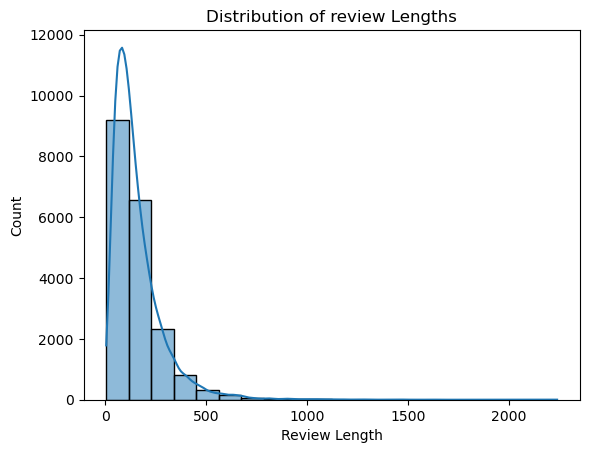

In [36]:
import seaborn as sns
train_data['text_length'] = train_data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=20, kde=True)
plt.title('Distribution of review Lengths')
plt.xlabel('Review Length')
plt.show()

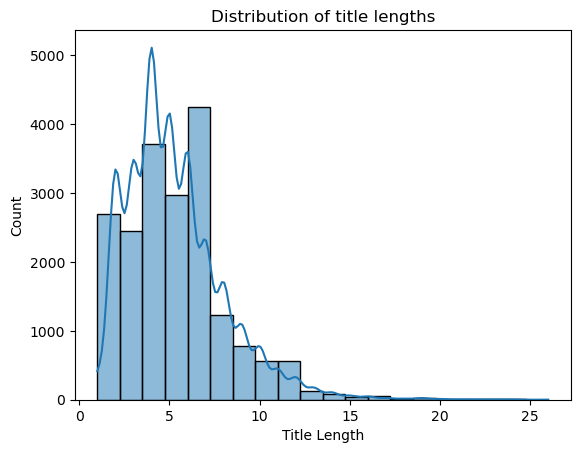

In [37]:
train_data['title_length'] = train_data['clean_title'].apply(lambda x: len(x.split()))
sns.histplot(train_data['title_length'], bins=20, kde=True)
plt.title('Distribution of title lengths')
plt.xlabel('Title Length')
plt.show()

[(5, 7928), (4, 6477), (3, 2669), (2, 1314), (1, 1180)]


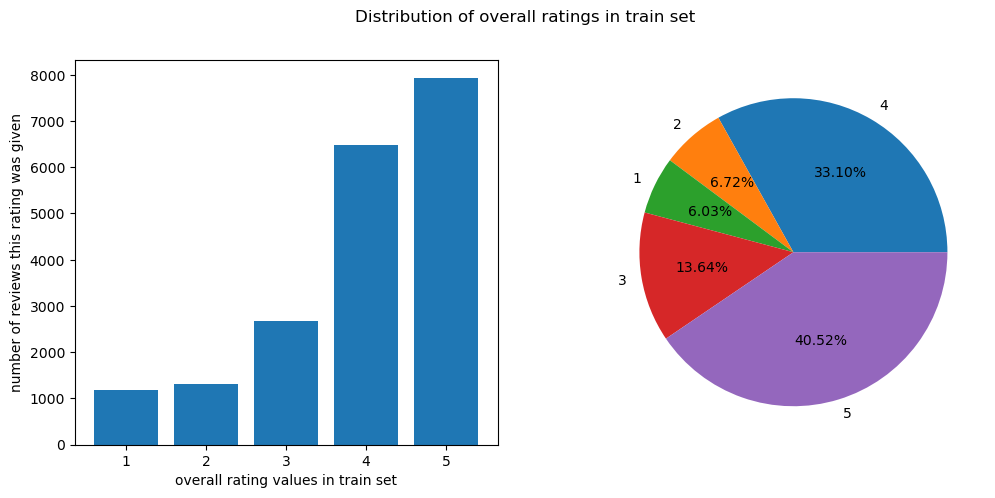

In [38]:
def overall_ratings_plot(data, type):
    ratings_distribution = []
    for i in range(len(data)):
        ratings_distribution.append(int(train_data['ratings'][i]['overall']))
    ratings_freq = Counter(ratings_distribution)
    print(sorted(ratings_freq.items(), key= lambda x:x[0], reverse=True))
    # total = sum(ratings_freq.values())
    # print(total)
    # print(f'{type} set ratings distribution:', ratings_freq)
    # ratios = [(val, round(cnt/total, 3)) for val, cnt in ratings_freq.items()]
    # print(f"percentage of dataset per rating: {sorted(ratios, key= lambda x:x[1], reverse = True)}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribution of overall ratings in {type} set')
    axes[0].bar(ratings_freq.keys(), ratings_freq.values())
    axes[0].set_xlabel(f'overall rating values in {type} set')
    axes[0].set_ylabel('number of reviews this rating was given')

    axes[1].pie (ratings_freq.values(), labels= ratings_freq.keys(), autopct='%1.2f%%')

overall_ratings_plot(train_data, 'train')

[(5, 2034), (4, 1573), (3, 681), (2, 337), (1, 277)]


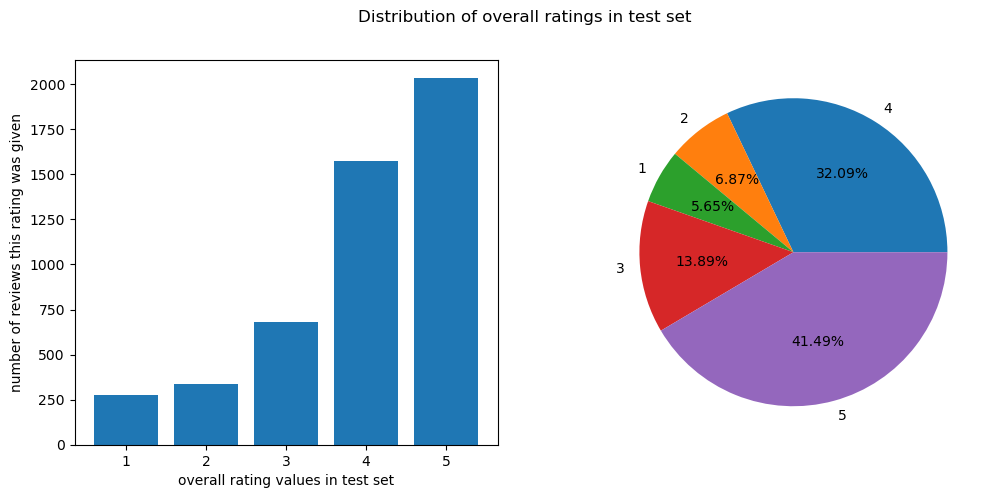

In [39]:
overall_ratings_plot(test_data, 'test')

In [40]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
train_data['stemmed_text'] = train_data['clean_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
train_data['stemmed_text']

0        close to union squar hotel is a bit of a maze ...
1        i had a bad vibe about thi place from the mome...
2        after we receiv our final bill and left the em...
3        step to grand central a veri well situat hotel...
4        thi hotel is locat right in the heart of san f...
                               ...                        
19563    we stay just one night here when visit our son...
19564    spent two night here with spous in conjunct wi...
19565    the room wa fairli larg pretti quiet the bed w...
19566    great start to our stay when we were check in ...
19567    great room comfort bed food is good the locat ...
Name: stemmed_text, Length: 19568, dtype: object

In [41]:
import spacy

nlp = spacy.load('en_core_web_sm')

#Noting: Lemmatization takes a while to run so running through pipe to speed it up (still takes ~2 mins)
def lemmatize(text):
    docs = list(nlp.pipe(text))
    return [' '.join([token.lemma_ for token in doc]) for doc in docs]

train_data['lemmatized_text'] = lemmatize(train_data['clean_text'])
train_data['lemmatized_text']

/Users/arpanmukhopadhyay/miniforge3/envs/mynewenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0        close to Union Square hotel be a bit of a maze...
1        I have a bad vibe about this place from the mo...
2        after we receive our final bill and leave the ...
3        step to Grand Central a very well situated hot...
4        this Hotel be locate right in the heart of San...
                               ...                        
19563    we stay just one night here when visit our son...
19564    spend two night here with spouse in conjunctio...
19565    the room be fairly large pretty quiet the bed ...
19566    great start to our stay when we be check in 2h...
19567    great room comfortable bed Food be good the lo...
Name: lemmatized_text, Length: 19568, dtype: object

In [42]:
a1 = train_data['stemmed_text'][4].split()
a2 = train_data['lemmatized_text'][4].split()
a3 = train_data['clean_text'][4].split()

print("Original Word | Stemmed Form | Lemmatized Form")
print("-" * 50)

for orig, stem, lemma in zip(a3, a1, a2):
    if stem != lemma:
        print(f"{orig:<13} | {stem:<12} | {lemma:<12}")


Original Word | Stemmed Form | Lemmatized Form
--------------------------------------------------
This          | thi          | this        
Hotel         | hotel        | Hotel       
is            | is           | be          
located       | locat        | locate      
San           | san          | San         
Francisco     | francisco    | Francisco   
Union         | union        | Union       
Square        | squar        | Square      
is            | is           | be          
Starbucks     | starbuck     | Starbucks   
coffee        | coffe        | coffee      
was           | wa           | be          
definite      | definit      | definite    
plus          | plu          | plus        
Cable         | cabl         | Cable       
service       | servic       | service     
remember      | rememb       | remember    
this          | thi          | this        
was           | wa           | be          
built         | built        | build       
thus          | thu   

using lemmatized text for further textual analysis as stemming can occasionally cut the actual word into its "stem" --> not very useful for model or eda

In [43]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['clean_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 55896
most frequent words use in reviews: [('the', 161669), ('and', 107255), ('a', 87419), ('to', 78738), ('was', 66404), ('I', 49981), ('in', 48093), ('of', 42344), ('The', 40069), ('is', 38690)]


In [44]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 55891


[('the', 161669),
 ('and', 107255),
 ('a', 87419),
 ('to', 78738),
 ('was', 66404),
 ('I', 49981),
 ('in', 48093),
 ('of', 42344),
 ('The', 40069),
 ('is', 38690)]

In [45]:
unique_words = set()
all_words = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    for w in data:
        unique_words.add(w)
        all_words.append(w)

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

#Note these are all stop words so should probably prune the dataset for stop words before looking for most common words
fdist = FreqDist(all_words)
fdist.most_common(10)

number of unique words: 48095


[('the', 201894),
 ('be', 166317),
 ('and', 108635),
 ('a', 89277),
 ('to', 79175),
 ('I', 61423),
 ('we', 51204),
 ('in', 49376),
 ('of', 42521),
 ('room', 39296)]

In [46]:
unique_words = set()
most_frequent_words = defaultdict(int)
for i in range(len(train_data)):
    data = train_data['lemmatized_text'][i].split()
    for w in data:
        unique_words.add(w)
        most_frequent_words[w] += 1

#vocab size of 62493 unique words in all the reviews
print(f"number of unique words: {len(unique_words)}")

most_freq = sorted(most_frequent_words.items(), key=lambda x: x[1], reverse=True)
print(f"most frequent words use in reviews: {most_freq[:10]}") #Notice how all of them are stop words --> dataset needs pruning

number of unique words: 48094
most frequent words use in reviews: [('the', 201894), ('be', 166317), ('and', 108635), ('a', 89277), ('to', 79175), ('I', 61423), ('we', 51204), ('in', 49376), ('of', 42521), ('room', 39296)]


In [47]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def most_common_words(N:list):
    most_frequent_actual_words = []

    for n in N:
        if n[0].lower() not in stop_words:
            most_frequent_actual_words.append(n)
        if len(most_frequent_actual_words) == 10:
            break

    return most_frequent_actual_words

most_frequent_actual_words = most_common_words(most_freq)
most_frequent_actual_words

[('room', 39296),
 ('hotel', 36555),
 ('stay', 24066),
 ('great', 13409),
 ('would', 11824),
 ('staff', 11734),
 ('get', 11692),
 ('good', 11626),
 ('night', 10370),
 ('nice', 9663)]

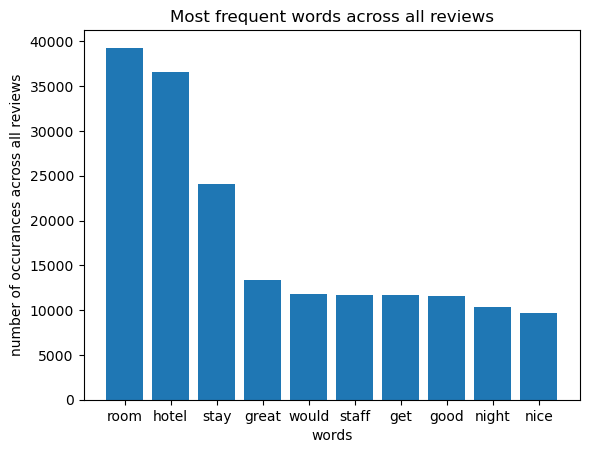

In [48]:
def plot_words(words, title_text, y_axis_text):
    words, counts = zip(*words)
    plt.bar(words, counts)
    plt.xlabel('words')
    plt.ylabel(y_axis_text)
    plt.title(title_text)

plot_words(most_frequent_actual_words,'Most frequent words across all reviews', 'number of occurances across all reviews')

In [49]:
def most_common_words_sentiment(N:list):
    negative_words = []
    positive_words = []
    for i in range(len(N)):
        data = word_tokenize(N['lemmatized_text'][i])
        rating = int(N['ratings'][i]['overall'])
        for w in data:
            if w.lower() in stop_words: continue
            if rating >= 2.5:
                positive_words.append(w)
            else:
                negative_words.append(w)
    
    return Counter(positive_words), Counter(negative_words)

positive_review_words, negative_review_words = most_common_words_sentiment(train_data)

print("Most common words in positive reviews: ")
positive_review_words.most_common(10)

Most common words in positive reviews: 


[('room', 32112),
 ('hotel', 31155),
 ('stay', 20749),
 ('great', 12859),
 ('good', 10506),
 ('staff', 10501),
 ('would', 9555),
 ('get', 9317),
 ('nice', 8877),
 ('night', 8407)]

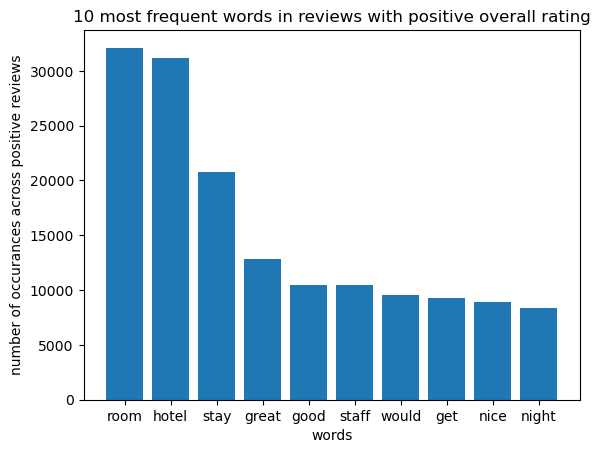

In [50]:
plot_words(positive_review_words.most_common(10),'10 most frequent words in reviews with positive overall rating', 'number of occurances across positive reviews')

In [51]:
print("Most common words in negative reviews:")
negative_review_words.most_common(10)

Most common words in negative reviews:


[('room', 7184),
 ('hotel', 5400),
 ('stay', 3317),
 ('get', 2375),
 ('would', 2269),
 ('night', 1963),
 ('one', 1790),
 ('go', 1742),
 ('say', 1364),
 ('could', 1336)]

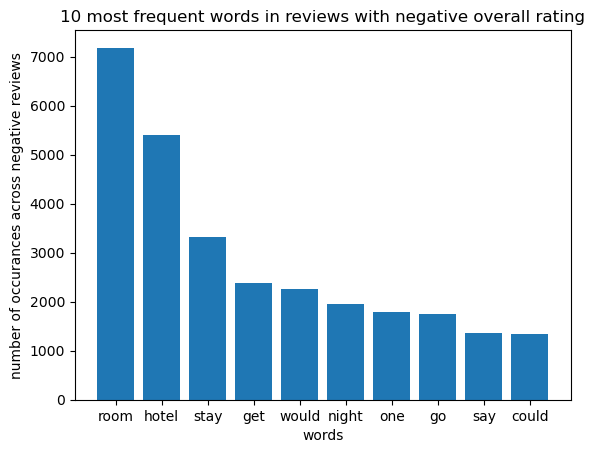

In [52]:
plot_words(negative_review_words.most_common(10),'10 most frequent words in reviews with negative overall rating', 'number of occurances across negative reviews')

In [53]:
from nltk import ngrams
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the front desk: 2419
The room was: 2412
in the room: 1849
of the hotel: 1749
The hotel is: 1696
stay here again: 1397
at this hotel: 1336
stayed at the: 1333
the room was: 1306
one of the: 1249


In [54]:
n = 3
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_grams_list = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    for gram in n_grams:
        n_grams_list.append(gram)

n_gram_freq = Counter(n_grams_list)

print(f"Distribution of {n}-grams:")
for ngram, count in n_gram_freq.most_common(10):
    print(f"{ngram}: {count}")

Distribution of 3-grams:
the room be: 7180
the hotel be: 4512
the staff be: 3447
the front desk: 3017
stay at the: 2983
there be a: 2873
I do not: 2264
in the room: 2201
it be a: 2126
the location be: 1955


Not very useful. What if we look at the most common tri grams for both "positive" and negative reviews?


In [55]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['clean_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
The room was: 2182
the front desk: 1721
The hotel is: 1587
of the hotel: 1514
in the room: 1439
stay here again: 1289
stayed at the: 1202
at this hotel: 1113
one of the: 1089
the room was: 1087


Most common 3-grams for negative rating reviews:
the front desk: 698
in the room: 410
of the hotel: 235
The room was: 230
I had to: 226
at this hotel: 223
the room was: 219
to the front: 169
we had to: 168
at the hotel: 164


In [56]:
positive_ngrams = []
negative_ngrams = []
for i in range(len(train_data)):
    data = word_tokenize(train_data['lemmatized_text'][i])
    n_grams = generate_ngrams(data, n)
    rating = int(train_data['ratings'][i]['overall'])
    if rating >= 2.5:
        for gram in n_grams:
            positive_ngrams.append(gram)
    else:
        for gram in n_grams:
            negative_ngrams.append(gram)

positive_ngrams_freq = Counter(positive_ngrams)
negative_ngrams_freq = Counter(negative_ngrams)

print(f"Most common {n}-grams for positive rating reviews:")
for ngram, count in positive_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")
print('\n')
print(f"Most common {n}-grams for negative rating reviews:")
for ngram, count in negative_ngrams_freq.most_common(10):
    print(f"{ngram}: {count}")


Most common 3-grams for positive rating reviews:
the room be: 6333
the hotel be: 4073
the staff be: 3213
stay at the: 2660
there be a: 2486
the front desk: 2220
it be a: 1894
the location be: 1803
I do not: 1766
in the room: 1725


Most common 3-grams for negative rating reviews:
the room be: 847
the front desk: 797
I do not: 498
in the room: 476
the hotel be: 439
there be no: 425
there be a: 387
stay at the: 323
this hotel be: 303
I have to: 283


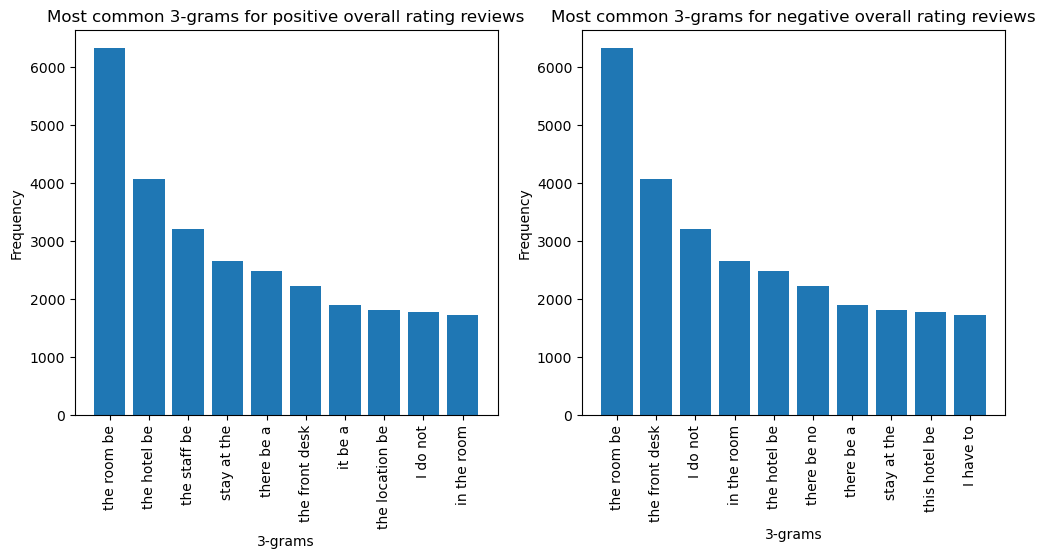

In [57]:
labels_pos, values_pos = zip(*positive_ngrams_freq.most_common(10))
labels_neg, values_neg = zip(*negative_ngrams_freq.most_common(10))
indexes = range(len(labels_pos))

lables = [labels_pos, labels_neg]
values = [values_pos, values_pos]

titles = [f"Most common {n}-grams for positive overall rating reviews", f"Most common {n}-grams for negative overall rating reviews"]
def multi_graph(indexes, labels, values, count, titles):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i in range(count):
        axes[i].bar(indexes, values[i])
        axes[i].set_xlabel(f'{n}-grams')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xticks(indexes, labels[i], rotation='vertical')
        axes[i].set_title(titles[i])

multi_graph(indexes, lables, values, 2, titles)

In [58]:
titles = train_data['clean_title']
title_words = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        title_words.append(w.lower())

print(Counter(title_words).most_common(10))

[('great', 5633), ('hotel', 4275), ('location', 3818), ('the', 3162), ('a', 2805), ('and', 2571), ('stay', 2367), ('in', 1949), ('for', 1893), ('good', 1852)]


In [59]:
title_words_ns = []
for n in train_data['clean_title']:
    title = word_tokenize(n)
    for w in title:
        if w.lower() not in stop_words:
            title_words_ns.append(w.lower())
            
print(Counter(title_words_ns).most_common(10))

[('great', 5633), ('hotel', 4275), ('location', 3818), ('stay', 2367), ('good', 1852), ('nice', 1362), ('service', 1300), ('staff', 1024), ('place', 1005), ('excellent', 667)]


Based off all these experiments, it becomes apparent that some additional changes must be made to the data before being fed into a machine learning model. Given the consistant requirement of lowercasing the words for both the title and the text, all the text should be normalised through lowercasing. Though this might remove some of the "textual emotion" conveyed in some of the reviews as capital letters could indicate both excitement and anger. But also these are not terribly useful considering how similar the good and the bad reviews seem to be in terms of word similar. So rather than frequency or even n-gram maybe we need to look deeper

### 3. Selection and training Machine Learning models

In [60]:
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda x: x.lower())
train_data['clean_title'] = train_data['clean_title'].apply(lambda x: x.lower())

In [61]:
train_data['clean_title'] = lemmatize(train_data['clean_title'])

In [62]:
def get_overall(ratings):
    try:
        return int(ratings.get('overall',None))
    except(AttributeError, TypeError):
        return None

train_data['overall'] = train_data['ratings'].apply(get_overall)
train_data['overall']

0        4
1        2
2        1
3        4
4        3
        ..
19563    4
19564    3
19565    5
19566    4
19567    5
Name: overall, Length: 19568, dtype: int64

In [63]:
lem_train_data = train_data[['overall', 'clean_title','lemmatized_text']]
stem_train_data =  train_data[['overall', 'clean_title','stemmed_text']]

In [64]:
lem_train_data

,overall,clean_title,lemmatized_text
0,4,great location and service,close to union square hotel be a bit of a maze...
1,2,I will never go back here again,i have a bad vibe about this place from the mo...
2,1,rip off our visa card after departure,after we receive our final bill and leave the ...
3,4,a great location,step to grand central a very well situated hot...
4,3,its all about the location,this hotel be locate right in the heart of san...
...,...,...,...
19563,4,pleasant stay with good location,we stay just one night here when visit our son...
19564,3,hit or miss some thing need attention,spend two night here with spouse in conjunctio...
19565,5,good breakfast,the room be fairly large pretty quiet the bed ...
19566,4,deserve a high rating,great start to our stay when we be check in 2h...


In [65]:
lem_train_data.loc[:, 'lemmatized_text'] = lem_train_data['clean_title'] + ' ' + lem_train_data['lemmatized_text']

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_absolute_error, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(lem_train_data["lemmatized_text"], 
                                                    lem_train_data["overall"], 
                                                    test_size=0.3, 
                                                    random_state=42)
print(len(X_train), len(X_test))

13697 5871


In [67]:
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
# # vectorizer = CountVectorizer(lowercase=True, token_pattern='[a-zA-Z0-9@#$%_]{2,}', \
# #                                  max_features=None)
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)

Multinomial Naive Bayes:
Accuracy: 0.5709
F1 score: 0.5387
Mean Absolute Error: 0.5314
              precision    recall  f1-score   support

           1       0.76      0.41      0.53       341
           2       0.12      0.01      0.01       370
           3       0.32      0.16      0.21       822
           4       0.47      0.63      0.54      1937
           5       0.70      0.78      0.74      2401

    accuracy                           0.57      5871
   macro avg       0.47      0.40      0.40      5871
weighted avg       0.54      0.57      0.54      5871



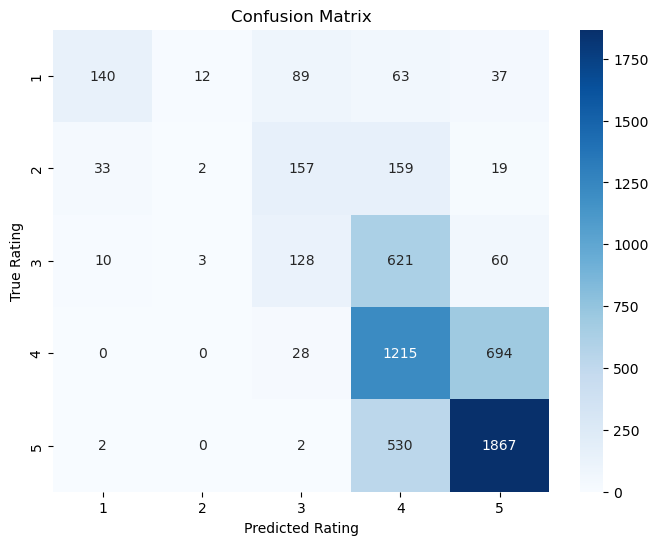

In [68]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_mnb)
acc = accuracy_score(y_test, y_pred_mnb)
weighted_f1 = f1_score(y_test, y_pred_mnb, average='weighted')

print("Multinomial Naive Bayes:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_mnb))

con_mat = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


SVM:
Accuracy: 0.6161
F1 score: 0.6053
Mean Absolute Error: 0.4396
              precision    recall  f1-score   support

           1       0.62      0.70      0.66       341
           2       0.36      0.20      0.26       370
           3       0.49      0.36      0.42       822
           4       0.55      0.58      0.57      1937
           5       0.72      0.78      0.75      2401

    accuracy                           0.62      5871
   macro avg       0.55      0.52      0.53      5871
weighted avg       0.60      0.62      0.61      5871



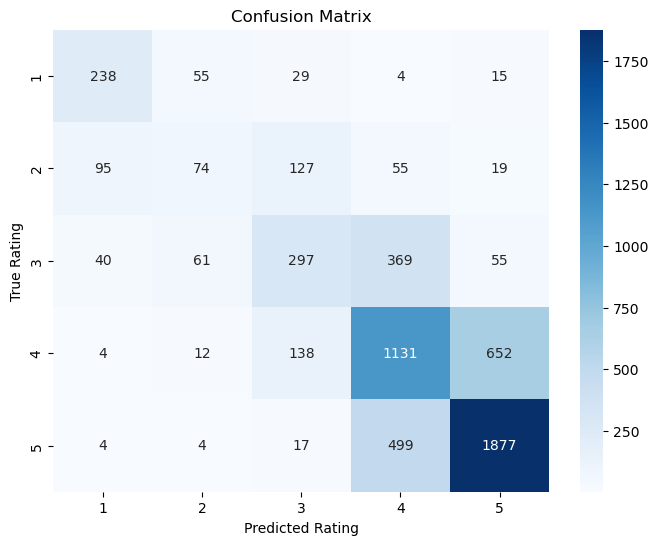

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LinearSVC(penalty='l1', dual=False, C=1))
])

pipeline.fit(X_train, y_train)
y_pred_svm = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))

con_mat = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()


Random Forest:
Accuracy: 0.4899
F1 score: 0.4144
Mean Absolute Error: 0.7701
              precision    recall  f1-score   support

           1       0.84      0.05      0.09       341
           2       0.20      0.00      0.01       370
           3       0.11      0.00      0.00       822
           4       0.39      0.44      0.41      1937
           5       0.55      0.83      0.67      2401

    accuracy                           0.49      5871
   macro avg       0.42      0.27      0.24      5871
weighted avg       0.43      0.49      0.41      5871



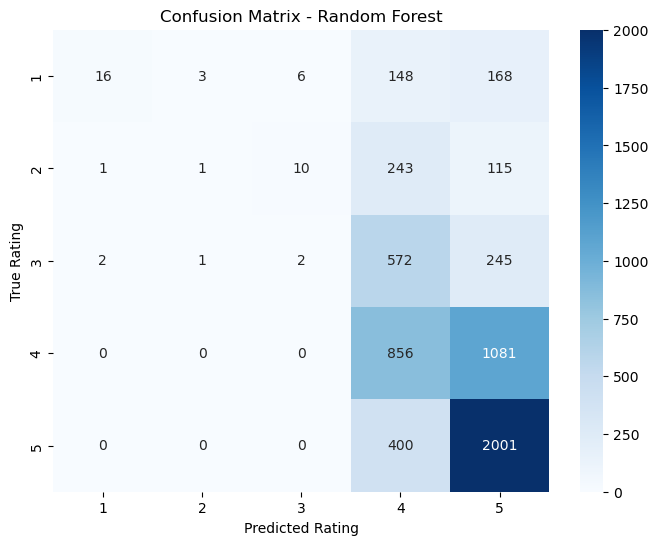

In [85]:
from sklearn.ensemble import RandomForestClassifier
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', RandomForestClassifier(
        n_estimators=100,     
        max_depth=None,       
        min_samples_split=2,  
        random_state=42       
    ))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [73]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# !python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

X_train, X_test, y_train, y_test = train_test_split(
    lem_train_data["lemmatized_text"], 
    lem_train_data["overall"], 
    test_size=0.3, 
    random_state=42
)
print(len(X_train), len(X_test))

13697 5871


In [74]:
import spacy
# !python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md') 

def document_vector_spacy(doc, nlp_model):
    doc = nlp_model(doc)
    return doc.vector

X_train_vectors = np.array([document_vector_spacy(doc, nlp) for doc in X_train])
X_test_vectors = np.array([document_vector_spacy(doc, nlp) for doc in X_test])

svm = SVC(kernel="linear", C=1)
svm.fit(X_train_vectors, y_train)

y_pred_svm = svm.predict(X_test_vectors)

mae = mean_absolute_error(y_test, y_pred_svm)
acc = accuracy_score(y_test, y_pred_svm)
weighted_f1 = f1_score(y_test, y_pred_svm, average='weighted')

print("SVM with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_svm))


SVM with word vectors:
Accuracy: 0.5774
F1 score: 0.5755
Mean Absolute Error: 0.4923
              precision    recall  f1-score   support

           1       0.55      0.66      0.60       341
           2       0.32      0.34      0.33       370
           3       0.46      0.35      0.40       822
           4       0.51      0.55      0.53      1937
           5       0.71      0.70      0.70      2401

    accuracy                           0.58      5871
   macro avg       0.51      0.52      0.51      5871
weighted avg       0.58      0.58      0.58      5871



Random Forest with word vectors:
Accuracy: 0.5231
F1 score: 0.4911
Mean Absolute Error: 0.6479
              precision    recall  f1-score   support

           1       0.60      0.35      0.45       341
           2       0.26      0.06      0.10       370
           3       0.35      0.13      0.19       822
           4       0.44      0.51      0.47      1937
           5       0.61      0.76      0.68      2401

    accuracy                           0.52      5871
   macro avg       0.45      0.36      0.38      5871
weighted avg       0.49      0.52      0.49      5871



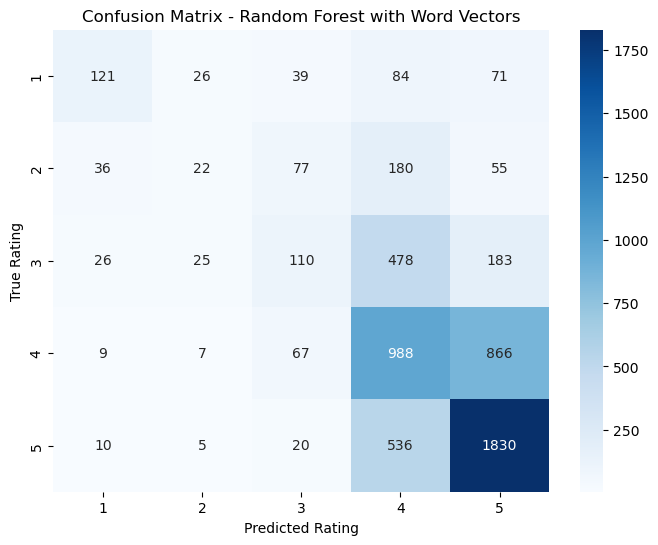

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='en_core_web_md'):
        self.model = model
        self.nlp = spacy.load(model)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return np.array([self.nlp(doc).vector for doc in X])

pipeline_rf_vectors = Pipeline([
    ('word_vectors', SpacyVectorTransformer(model='en_core_web_md')),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ))
])

pipeline_rf_vectors.fit(X_train, y_train)

y_pred_rf = pipeline_rf_vectors.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
acc = accuracy_score(y_test, y_pred_rf)
weighted_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print("Random Forest with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_rf))

con_mat = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - Random Forest with Word Vectors')
plt.show()

XGBoost with word vectors:
Accuracy: 0.5384
F1 score: 0.5234
Mean Absolute Error: 0.5825
              precision    recall  f1-score   support

           1       0.57      0.49      0.52       341
           2       0.29      0.15      0.20       370
           3       0.37      0.24      0.29       822
           4       0.46      0.50      0.48      1937
           5       0.65      0.74      0.69      2401

    accuracy                           0.54      5871
   macro avg       0.47      0.42      0.44      5871
weighted avg       0.52      0.54      0.52      5871



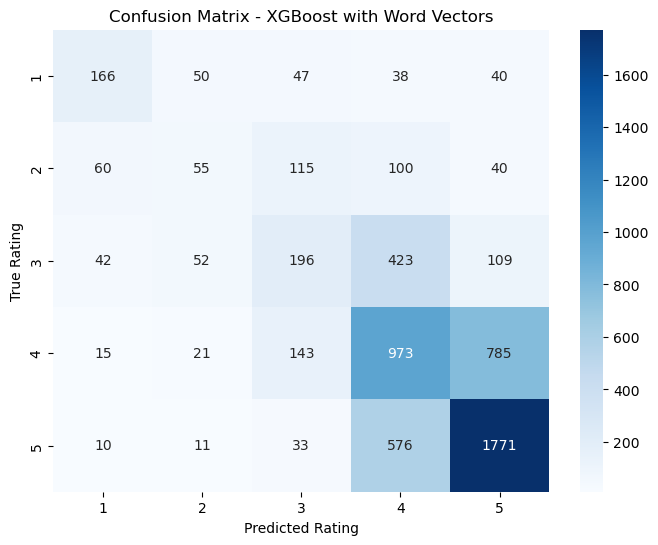

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, model='en_core_web_md'):
#         self.model = model
#         self.nlp = spacy.load(model)
    
#     def fit(self, X, y=None):
#         return self
        
#     def transform(self, X):
#         return np.array([self.nlp(doc).vector for doc in X])

pipeline_xgb_vectors = Pipeline([
    ('word_vectors', SpacyVectorTransformer(model='en_core_web_md')),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=5,          
        learning_rate=0.1,    
        objective='multi:softmax', 
        random_state=42,
        enable_categorical=True,
        num_class=5,
    ))
])


pipeline_xgb_vectors.fit(X_train, y_train_encoded)

y_pred_encoded = pipeline_xgb_vectors.predict(X_test)
y_pred_xgb = label_encoder.inverse_transform(y_pred_encoded)

mae = mean_absolute_error(y_test, y_pred_xgb)
acc = accuracy_score(y_test, y_pred_xgb)
weighted_f1 = f1_score(y_test, y_pred_xgb, average='weighted')

print("XGBoost with word vectors:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {weighted_f1:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(classification_report(y_test, y_pred_xgb))

con_mat = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(1, 6),
           yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix - XGBoost with Word Vectors')
plt.show()

### 4. Experiment with VADER sentiment lexicon

In [58]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    score = sentiment.polarity_scores(text)
    return score['compound']

lem_train_data.loc[:, 'vader_score'] = lem_train_data['lemmatized_text'].apply(sentiment_scores)
lem_train_data


,overall,clean_title,lemmatized_text,vader_score,vader_rating,rating_discrepancy
0,1,horrible experience,horrible experience first of all we get there ...,0.8192,5,4
1,1,stay away,stay away find racist graffiti in the room req...,-0.8225,1,0
2,4,great location and service,great location and service close to union squa...,0.8479,5,1
3,2,I will never go back here again,I will never go back here again i have a bad v...,0.9418,5,3
4,1,rip off our visa card after departure,rip off our visa card after departure after we...,0.4215,4,3
...,...,...,...,...,...,...
23993,4,pleasant stay with good location,pleasant stay with good location we stay just ...,0.9681,5,1
23994,3,hit or miss some thing need attention,hit or miss some thing need attention spend tw...,-0.8971,1,2
23995,5,good breakfast,good breakfast the room be fairly large pretty...,0.8689,5,0
23996,4,deserve a high rating,deserve a high rating great start to our stay ...,0.9682,5,1


In [59]:
def vader_classification(score):
    if score >= 0.5:
        return 5
    elif score > 0.2:
        return 4
    elif score > -0.2:
        return 3
    elif score >= -0.5:
        return 2
    else:
        return 1
    
lem_train_data.loc[:, 'vader_rating'] = lem_train_data['vader_score'].apply(vader_classification)
lem_train_data['vader_rating']
lem_train_data.loc[:, 'rating_discrepancy'] = abs(lem_train_data['overall'] - lem_train_data['vader_rating'])
lem_train_data

,overall,clean_title,lemmatized_text,vader_score,vader_rating,rating_discrepancy
0,1,horrible experience,horrible experience first of all we get there ...,0.8192,5,4
1,1,stay away,stay away find racist graffiti in the room req...,-0.8225,1,0
2,4,great location and service,great location and service close to union squa...,0.8479,5,1
3,2,I will never go back here again,I will never go back here again i have a bad v...,0.9418,5,3
4,1,rip off our visa card after departure,rip off our visa card after departure after we...,0.4215,4,3
...,...,...,...,...,...,...
23993,4,pleasant stay with good location,pleasant stay with good location we stay just ...,0.9681,5,1
23994,3,hit or miss some thing need attention,hit or miss some thing need attention spend tw...,-0.8971,1,2
23995,5,good breakfast,good breakfast the room be fairly large pretty...,0.8689,5,0
23996,4,deserve a high rating,deserve a high rating great start to our stay ...,0.9682,5,1


In [60]:
mean_discrepancy = lem_train_data['rating_discrepancy'].mean()
print(f"The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: {mean_discrepancy:.4f}")

The average discrepancy between vader sentiment rating based on text and ground truth rating given by customer is: 0.8142


accuracy: 0.4547
precision: 0.3565
recall: 0.4547
f1_weighted: 0.3209
              precision    recall  f1-score   support

           1       0.52      0.52      0.52      1557
           2       0.29      0.06      0.11      1611
           3       0.31      0.05      0.08      3287
           4       0.22      0.02      0.03      7720
           5       0.46      0.99      0.63      9823

    accuracy                           0.45     23998
   macro avg       0.36      0.33      0.27     23998
weighted avg       0.36      0.45      0.32     23998



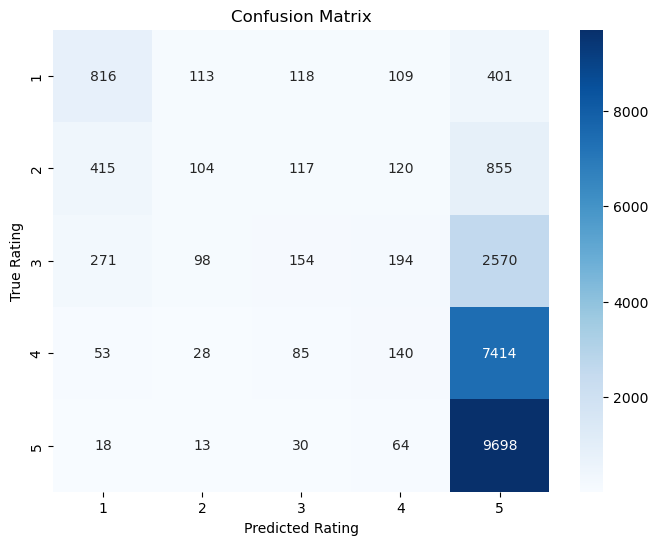

In [61]:
y_true, y_pred = lem_train_data['overall'], lem_train_data['vader_rating']

accuracy = accuracy_score(y_true, y_pred)
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'accuracy: {accuracy:.4f}')
print(f'precision: {precision_weighted:.4f}')
print(f'recall: {recall_weighted:.4f}')
print(f'f1_weighted: {f1_weighted:.4f}')

print(classification_report(y_true, y_pred))

con_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, 6),
            yticklabels=range(1, 6))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

### Appendix